# Projet 2 - NLP : Génération de texte

## Étape 1 : Préparation du corpus

In [3]:
# 1. Importer les librairies
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from collections import Counter

# Télécharger les ressources NLTK si besoin
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mmf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
#2. Charger et prévisualiser le corpus
with open('data/poems.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("Aperçu du corpus :")
print(text[:500])

Aperçu du corpus :
Two roads diverged in a yellow wood,
And sorry I could not travel both
And be one traveler, long I stood
And looked down one as far as I could
To where it bent in the undergrowth;

I wandered lonely as a cloud
That floats on high o'er vales and hills,
When all at once I saw a crowd,
A host, of golden daffodils;
Beside the lake, beneath the trees,
Fluttering and dancing in the breeze.

Hope is the thing with feathers
That perches in the soul,
And sings the tune without the words,
And never stops 


## Étape 2 : Tokenisation et vocabulaire

In [5]:
#3. Tokenisation
tokens = word_tokenize(text)
print(f"Nombre de tokens : {len(tokens)}")
print(f"Premiers 20 tokens : {tokens[:20]}")

Nombre de tokens : 153
Premiers 20 tokens : ['Two', 'roads', 'diverged', 'in', 'a', 'yellow', 'wood', ',', 'And', 'sorry', 'I', 'could', 'not', 'travel', 'both', 'And', 'be', 'one', 'traveler', ',']


In [6]:
# 4. Construire le vocabulaire et les mappings
vocab = sorted(set(tokens))
print(f"Taille du vocabulaire : {len(vocab)}")

token_to_idx = {tok: idx for idx, tok in enumerate(vocab)}
idx_to_token = {idx: tok for tok, idx in token_to_idx.items()}

# Exemple de conversion tokens → indices
indices = [token_to_idx[tok] for tok in tokens[:10]]
print(f"Indices exemple : {indices}")

Taille du vocabulaire : 101
Indices exemple : [17, 69, 40, 51, 19, 99, 97, 0, 6, 75]


10 tokens les plus fréquents : [(',', 10), ('the', 9), ('And', 6), ('I', 6), ('a', 5), ('in', 4), ('as', 3), (';', 3), ('and', 3), ('all', 3)]


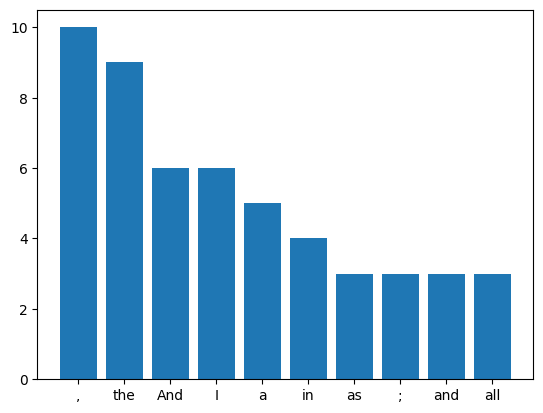

In [7]:
# 5. Analyse simple : fréquence des tokens
counter = Counter(tokens)
most_common = counter.most_common(10)
print("10 tokens les plus fréquents :", most_common)

words, counts = zip(*most_common)
plt.bar(words, counts)
plt.show()

In [8]:
# 6. Préparer les séquences pour le modèle
# Taille des séquences d'entrée
seq_length = 5

# Conversion complète des tokens en indices
indices = [token_to_idx[tok] for tok in tokens]

# Préparer les séquences d'entrée (X) et la cible (Y)
inputs = []
targets = []
for i in range(len(indices) - seq_length):
    inputs.append(indices[i:i+seq_length])
    targets.append(indices[i+seq_length])

print(f"Exemple d'entrée (indices) : {inputs[0]}")
print(f"Exemple de cible (index) : {targets[0]}")

Exemple d'entrée (indices) : [17, 69, 40, 51, 19]
Exemple de cible (index) : 99


In [9]:
# 7. Dataset et DataLoader PyTorch
class TextDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

dataset = TextDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [10]:
# 8. Définir un modèle RNN simple
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.rnn(embedded)
        out = out[:, -1, :]  # dernière sortie RNN
        out = self.fc(out)
        return out

vocab_size = len(vocab)
embedding_dim = 32
hidden_dim = 64

model = RNNModel(vocab_size, embedding_dim, hidden_dim)

In [11]:
# 9. Entraînement rapide
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for batch_inputs, batch_targets in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.4f}")

Epoch 1/5 - Loss: 4.6502
Epoch 2/5 - Loss: 4.4867
Epoch 3/5 - Loss: 4.3378
Epoch 4/5 - Loss: 4.2248
Epoch 5/5 - Loss: 4.0795


In [12]:
# 10. Génération de texte simple
def generate_text(model, start_seq, idx_to_token, token_to_idx, length=20):
    model.eval()
    generated = start_seq.copy()
    
    for _ in range(length):
        # Préparer la séquence en indices
        seq_indices = [token_to_idx.get(tok, 0) for tok in generated[-seq_length:]]
        seq_tensor = torch.tensor(seq_indices).unsqueeze(0)  # batch=1
        
        with torch.no_grad():
            output = model(seq_tensor)
            prob = nn.functional.softmax(output, dim=1)
            next_idx = torch.multinomial(prob, num_samples=1).item()
            next_tok = idx_to_token[next_idx]
            generated.append(next_tok)
    
    return ' '.join(generated)

# Exemple d'utilisation :
start_seq = tokens[:seq_length]
print("Texte généré :")
print(generate_text(model, start_seq, idx_to_token, token_to_idx, length=30))

Texte généré :
Two roads diverged in a yellow without ’ date art To temperate perches Fluttering ; too a bent more never To daffodils short Beside it buds And be To stops without wandered one trees once


In [13]:
# Préparer les séquences d’entraînement (input / target) pour génération de texte
# Taille des séquences (exemple 5 tokens par séquence)
seq_length = 5

# Préparer les séquences (X) et les cibles (Y)
input_sequences = []
target_tokens = []

for i in range(len(tokens) - seq_length):
    seq_in = tokens[i:i + seq_length]
    seq_out = tokens[i + seq_length]
    input_sequences.append([token_to_idx[tok] for tok in seq_in])
    target_tokens.append(token_to_idx[seq_out])

print(f"Nombre de séquences: {len(input_sequences)}")
print(f"Exemple de séquence (indices): {input_sequences[0]}")
print(f"Token cible pour cette séquence: {target_tokens[0]} ({idx_to_token[target_tokens[0]]})")


Nombre de séquences: 148
Exemple de séquence (indices): [17, 69, 40, 51, 19]
Token cible pour cette séquence: 99 (yellow)


In [14]:
#Créer un Dataset et DataLoader PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

dataset = TextDataset(input_sequences, target_tokens)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [15]:
#Définir un modèle RNN simple avec embeddings
import torch.nn as nn

class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)               # (batch, seq_len, embed_dim)
        output, hidden = self.rnn(x)       # output: (batch, seq_len, hidden_dim)
        out = self.fc(output[:, -1, :])    # prendre sortie du dernier pas de temps
        return out

vocab_size = len(vocab)
embed_dim = 64
hidden_dim = 128
model = SimpleRNNModel(vocab_size, embed_dim, hidden_dim)


In [16]:
#Configurer la fonction de perte et l’optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [17]:
#Entraîner le modèle (exemple de boucle sur 10 epochs)
epochs = 10
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch_inputs, batch_targets in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")


Epoch 1/10, Loss: 4.6356
Epoch 2/10, Loss: 4.3619
Epoch 3/10, Loss: 4.1529
Epoch 4/10, Loss: 3.9471
Epoch 5/10, Loss: 3.7391
Epoch 6/10, Loss: 3.5175
Epoch 7/10, Loss: 3.3183
Epoch 8/10, Loss: 3.0838
Epoch 9/10, Loss: 2.8790
Epoch 10/10, Loss: 2.6413


In [18]:
#Génération de texte avec le modèle entraîné
model.eval()

def generate_text(model, start_seq, length=20):
    model.eval()
    tokens_generated = start_seq.copy()
    for _ in range(length):
        input_seq = [token_to_idx.get(tok, 0) for tok in tokens_generated[-seq_length:]]
        input_tensor = torch.tensor([input_seq], dtype=torch.long)
        with torch.no_grad():
            output = model(input_tensor)
            predicted_idx = output.argmax(dim=1).item()
            tokens_generated.append(idx_to_token[predicted_idx])
    return ' '.join(tokens_generated)

# Exemple avec une séquence de départ
start_sequence = tokens[:seq_length]
print("Texte généré :")
print(generate_text(model, start_sequence))


Texte généré :
Two roads diverged in a yellow wood , And summer ’ s lease hath all too short a date ; , And sings the tune


## Étape 3 : Embedding + LSTM

In [19]:
#Définir un modèle LSTM simple avec embedding
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        logits = self.fc(output)
        return logits, hidden


In [20]:
#Initialiser le modèle, optimiser et loss function
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 2

model = LSTMModel(vocab_size, embed_size, hidden_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [21]:
# Entraînement (boucle sur epochs) et Génération de texte avec le modèle entraîné

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [22]:
# Préparation des séquences (exemple simple)
seq_length = 10

def create_sequences(tokens, seq_length):
    indices = [token_to_idx[t] for t in tokens]
    inputs = []
    targets = []
    for i in range(len(indices) - seq_length):
        inputs.append(indices[i:i+seq_length])
        targets.append(indices[i+1:i+seq_length+1])
    return torch.tensor(inputs), torch.tensor(targets)

inputs, targets = create_sequences(tokens, seq_length)

dataset = TensorDataset(inputs, targets)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [23]:
# Initialisation modèle, optimizer, loss (à adapter si déjà défini)
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 2

model = LSTMModel(vocab_size, embed_size, hidden_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
print_every = 100

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output, _ = model(x_batch)  # output shape: (batch, seq_len, vocab_size)
        output = output.view(-1, vocab_size)
        y_batch = y_batch.view(-1)

        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % print_every == 0:
            avg_loss = running_loss / print_every
            print(f"Epoch {epoch+1}/{epochs}, Step {i+1}/{len(dataloader)}, Loss: {avg_loss:.4f}")
            running_loss = 0.0

In [24]:
# Génération de texte avec le modèle entraîné
model.eval()

def generate_text(model, start_text, length=50, temperature=1.0):
    model.eval()
    tokens_generated = []
    input_seq = [token_to_idx.get(t, 0) for t in start_text.split()]
    input_seq = input_seq[-seq_length:]  # s'assurer que la séquence est <= seq_length

    hidden = None
    for _ in range(length):
        x = torch.tensor(input_seq).unsqueeze(0).to(device)  # (1, seq_len)
        with torch.no_grad():
            output, hidden = model(x, hidden)

        logits = output[0, -1] / temperature  # logits du dernier token prédit
        probs = F.softmax(logits, dim=0).cpu().numpy()
        next_token_idx = np.random.choice(len(probs), p=probs)
        tokens_generated.append(idx_to_token[next_token_idx])

        input_seq.append(next_token_idx)
        input_seq = input_seq[1:]  # glisser la fenêtre

    return " ".join(tokens_generated)

start_phrase = "Two roads diverged in a"
generated = generate_text(model, start_phrase, length=50, temperature=0.8)
print("\nTexte généré :\n", start_phrase + " " + generated)


Texte généré :
 Two roads diverged in a wood wood I I I not And travel one traveler traveler long I And be one far long I I And one as as To where where in bent the ; I lonely as That where high o'er bent the , , And I the tune , host , And


# Étape 4 : Modèle RNN avec encodage One-hot

In [25]:
import torch
import torch.nn as nn

# Exemple de séquence de caractères (indices)
sequence = torch.tensor([0, 2, 1, 3])  # exemple d’indices de caractères dans le vocabulaire
vocab_size = 5  # taille du vocabulaire

# One-hot encoding
one_hot = torch.nn.functional.one_hot(sequence, num_classes=vocab_size).float()
print("One-hot encoding shape:", one_hot.shape)
print(one_hot)

# Exemple d’un RNN simple qui prend du one-hot en entrée
rnn = nn.RNN(input_size=vocab_size, hidden_size=10, batch_first=True)

# Ajouter batch dimension et seq_length dimension (ici batch=1, seq_len=4)
input_rnn = one_hot.unsqueeze(0)  # shape (1, seq_len, vocab_size)

output, hidden = rnn(input_rnn)

print("RNN output shape:", output.shape)


One-hot encoding shape: torch.Size([4, 5])
tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])
RNN output shape: torch.Size([1, 4, 10])


In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Exemple de corpus (à remplacer par tes poèmes, citations, etc.)
corpus = text.lower()
chars = sorted(list(set(corpus)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}
vocab_size = len(chars)

# Dataset utilisant des indices d'entiers (pas de one-hot)
class CharDataset(Dataset):
    def __init__(self, text, char_to_idx, seq_len=50):
        self.data = [char_to_idx[ch] for ch in text]
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+self.seq_len+1], dtype=torch.long)
        return x, y

seq_len = 50
dataset = CharDataset(corpus, char_to_idx, seq_len)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [27]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=256, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, embedding_dim)
        output, _ = self.lstm(embedded)
        logits = self.fc(output)     # (batch, seq_len, vocab_size)
        return logits


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CharRNN(vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

epochs = 10
model.train()
for epoch in range(epochs):
    total_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output.view(-1, vocab_size), y_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(dataloader):.4f}")


Epoch 1/10 | Loss: 3.0761
Epoch 2/10 | Loss: 2.5885
Epoch 3/10 | Loss: 2.0202
Epoch 4/10 | Loss: 1.4501
Epoch 5/10 | Loss: 0.8798
Epoch 6/10 | Loss: 0.4555
Epoch 7/10 | Loss: 0.2404
Epoch 8/10 | Loss: 0.1614
Epoch 9/10 | Loss: 0.1307
Epoch 10/10 | Loss: 0.1143


In [29]:
import torch.nn.functional as F

def generate_text(model, start_char, char_to_idx, idx_to_char, length=200, temperature=1.0, device='cpu'):
    model.eval()
    input_idx = torch.tensor([[char_to_idx[start_char]]], dtype=torch.long).to(device)
    generated = start_char

    with torch.no_grad():
        hidden = None
        for _ in range(length):
            output = model(input_idx)
            logits = output[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1).item()
            next_char = idx_to_char[next_idx]
            generated += next_char
            input_idx = torch.tensor([[next_idx]], dtype=torch.long).to(device)

    return generated

# Exemple
print(generate_text(model, start_char='l', char_to_idx=char_to_idx, idx_to_char=idx_to_char, device=device, temperature=0.8))


l,
ther;:er oke h ollod t oug n bends cind
and be ke be be fe in ane s c the an sing ar aratherake athe,
ath in ovend g but sthe ou?.
th whids wouloi t al,
azerind
ay ulme ithalodaly
and t s ithoutry, 


Entraîner un tokenizer BPE sur notre corpus (avec SentencePiece)

In [30]:
import sentencepiece as spm

# Entraînement BPE
spm.SentencePieceTrainer.train(
    input='data/poems.txt',
    model_prefix='models/bpe_model',
    vocab_size=500,           # tu peux ajuster (plus gros si texte long)
    model_type='bpe',         # 'unigram', 'word', etc. aussi dispo
    character_coverage=1.0,   # pour texte anglais
    bos_id=-1,
    eos_id=-1
)


In [31]:
#Charger le tokenizer pour encoder/décoder du texte
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.load("models/bpe_model.model")


True

In [32]:
# Tokeniser un texte (→ indices)
text = corpus
token_ids = sp.encode(text, out_type=int)
print(token_ids)  # → [215, 98, 47, ...]
tokens = sp.encode(text, out_type=str)
print(tokens)  # → ['▁This', '▁is', '▁an', '▁ex', 'ample', ...]



[13, 107, 226, 257, 30, 2, 250, 217, 474, 46, 230, 54, 78, 185, 80, 202, 46, 65, 72, 259, 474, 211, 54, 231, 46, 246, 206, 72, 43, 182, 43, 54, 78, 70, 236, 153, 201, 30, 7, 264, 485, 54, 260, 245, 43, 2, 221, 5, 20, 243, 155, 208, 12, 489, 3, 235, 46, 223, 474, 156, 34, 45, 64, 212, 54, 187, 2, 222, 474, 2, 209, 474, 67, 244, 261, 485, 18, 193, 7, 210, 474, 251, 7, 234, 474, 39, 313, 240, 46, 253, 30, 7, 242, 487, 28, 137, 152, 7, 233, 77, 258, 5, 20, 255, 30, 7, 213, 474, 46, 229, 7, 215, 256, 7, 238, 474, 46, 225, 232, 64, 45, 487, 68, 372, 54, 252, 214, 70, 2, 79, 488, 468, 180, 491, 5, 16, 178, 76, 247, 46, 76, 262, 490, 112, 169, 237, 149, 227, 7, 254, 203, 67, 56, 276, 474, 46, 79, 488, 468, 224, 207, 45, 188, 228, 2, 205, 485]
['▁t', 'wo', '▁roads', '▁diverged', '▁in', '▁a', '▁yellow', '▁wood', ',', '▁and', '▁sorry', '▁i', '▁could', '▁not', '▁travel', '▁both', '▁and', '▁be', '▁one', '▁traveler', ',', '▁long', '▁i', '▁stood', '▁and', '▁looked', '▁down', '▁one', '▁as', '▁far', '▁

In [33]:
#Reconstruire le texte à partir des IDs
decoded = sp.decode(token_ids)
print(decoded)  # → "This is an example sentence."


two roads diverged in a yellow wood, and sorry i could not travel both and be one traveler, long i stood and looked down one as far as i could to where it bent in the undergrowth; i wandered lonely as a cloud that floats on high o'er vales and hills, when all at once i saw a crowd, a host, of golden daffodils; beside the lake, beneath the trees, fluttering and dancing in the breeze. hope is the thing with feathers that perches in the soul, and sings the tune without the words, and never stops at all. shall i compare thee to a summer’s day? thou art more lovely and more temperate: rough winds do shake the darling buds of may, and summer’s lease hath all too short a date;


In [34]:
#Utiliser les IDs comme entrée pour un modèle de génération de texte
import torch

# Exemple : encode le texte puis convertit en tenseur
input_tensor = torch.tensor(token_ids).unsqueeze(0)  # shape (1, seq_len)


In [35]:
#générer du texte à partir d’un start_seq (tokens)
import torch
import torch.nn as nn
import torch.nn.functional as F

# Modèle LSTM simple avec embedding, compatible gestion du hidden state
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        logits = self.fc(output)
        return logits, hidden


# Fonction de génération de texte
def generate_text(model, start_seq, idx_to_token, token_to_idx, seq_length, length=50, temperature=1.0):
    model.eval()
    generated = start_seq.copy()  # liste de tokens

    hidden = None  # état initial caché

    for _ in range(length):
        # Préparer la séquence d'entrée (indices) sur la fenêtre de seq_length
        seq_indices = [token_to_idx.get(tok, 0) for tok in generated[-seq_length:]]
        seq_tensor = torch.tensor(seq_indices).unsqueeze(0)  # shape (1, seq_length)

        with torch.no_grad():
            logits, hidden = model(seq_tensor, hidden)

            # Prendre les logits du dernier pas de temps
            logits = logits[:, -1, :]  # shape (1, vocab_size)

            # Appliquer température
            logits = logits / temperature

            # Softmax pour obtenir une distribution de probas
            probs = F.softmax(logits, dim=-1)

            # Échantillonner le prochain token
            next_token_id = torch.multinomial(probs, num_samples=1).item()

            # Convertir en token
            next_token = idx_to_token[next_token_id]

            generated.append(next_token)

    return ' '.join(generated)



vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 2
seq_length = 30  # par exemple

model = LSTMModel(vocab_size, embed_size, hidden_size, num_layers)

start_seq = tokens[:seq_length]

generated_text = generate_text(model, start_seq, idx_to_token, token_to_idx, seq_length, length=50, temperature=0.8)

print("Texte généré :")
print(generated_text)


Texte généré :
▁t wo ▁roads ▁diverged ▁in ▁a ▁yellow ▁wood , ▁and ▁sorry ▁i ▁could ▁not ▁travel ▁both ▁and ▁be ▁one ▁traveler , ▁long ▁i ▁stood ▁and ▁looked ▁down ▁one ▁as ▁far o'er roads the of Two wandered it stops hath could lovely soul That high thing . it lease as too hath crowd sings vales thing ? down could Fluttering a , vales trees That it down trees not Shall roads too wood stops day vales traveler looked a That stops


In [36]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, tokens, token_to_idx, seq_length):
        self.token_to_idx = token_to_idx
        self.seq_length = seq_length
        self.indices = [token_to_idx.get(t, 0) for t in tokens]

    def __len__(self):
        # Nombre total de séquences
        return len(self.indices) - self.seq_length

    def __getitem__(self, idx):
        # Séquence d'entrée
        x = self.indices[idx : idx + self.seq_length]
        # Cible = séquence décalée d'un token
        y = self.indices[idx + 1 : idx + self.seq_length + 1]
        return torch.tensor(x), torch.tensor(y)

# Paramètres
seq_length = 30  # à ajuster

# Création dataset & dataloader
dataset = TextDataset(tokens, token_to_idx, seq_length)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [37]:
import torch.nn.functional as F

num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        logits, _ = model(x_batch)  # logits shape: (batch_size, seq_length, vocab_size)

        # Reshape pour CrossEntropyLoss : (batch_size * seq_length, vocab_size)
        logits = logits.view(-1, vocab_size)
        y_batch = y_batch.view(-1)

        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")


Epoch 1/10 - Loss: 4.6121
Epoch 2/10 - Loss: 4.6116
Epoch 3/10 - Loss: 4.6116
Epoch 4/10 - Loss: 4.6121
Epoch 5/10 - Loss: 4.6114
Epoch 6/10 - Loss: 4.6116
Epoch 7/10 - Loss: 4.6120
Epoch 8/10 - Loss: 4.6121
Epoch 9/10 - Loss: 4.6123
Epoch 10/10 - Loss: 4.6118


In [38]:
torch.save(model.state_dict(), 'models/lstm_model.pth')


In [39]:
model.eval()

start_seq = tokens[:seq_length]  # ou une phrase d’amorce
generated_text = generate_text(model, start_seq, idx_to_token, token_to_idx, length=50, temperature=0.8, seq_length=seq_length)

print("Texte généré :")
print(generated_text)


Texte généré :
▁t wo ▁roads ▁diverged ▁in ▁a ▁yellow ▁wood , ▁and ▁sorry ▁i ▁could ▁not ▁travel ▁both ▁and ▁be ▁one ▁traveler , ▁long ▁i ▁stood ▁and ▁looked ▁down ▁one ▁as ▁far s hath : thee perches yellow high crowd be May lake crowd travel hath words summer floats all . all ? . is of and hath it one cloud roads That hills without be wood once darling stops the lonely s to hath temperate saw tune at , is And


Autoencodeur : Définir un modèle Seq2Seq simple avec LSTM

In [40]:
import torch
import torch.nn as nn

class Seq2SeqAutoencoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, src, tgt):
        # Embedding
        embedded_src = self.embedding(src)  # (B, T, E)
        embedded_tgt = self.embedding(tgt)  # (B, T, E)
        
        # Encoder
        _, (hidden, cell) = self.encoder(embedded_src)

        # Decoder avec le hidden + cell du encodeur
        decoder_outputs, _ = self.decoder(embedded_tgt, (hidden, cell))

        # Output vocab logits
        logits = self.output_layer(decoder_outputs)  # (B, T, vocab_size)

        return logits


In [ ]:
special_tokens = ['<bos>', '<eos>', '<unk>']

for token in special_tokens:
    if token not in token_to_idx:
        idx = len(token_to_idx)
        token_to_idx[token] = idx
        idx_to_token[idx] = token

src_seq = [token_to_idx.get(tok, token_to_idx['<unk>']) for tok in tokens]
tgt_seq = [token_to_idx['<bos>']] + src_seq[:-1]

src_tensor = torch.tensor(src_seq).unsqueeze(0)  # (1, T)
tgt_tensor = torch.tensor(tgt_seq).unsqueeze(0)  # (1, T)



décodage